In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import os

%matplotlib inline

## Read and wrangle data

### First, set up important variables

In [6]:
TRAIN_DIR = "../train/"
TEST_DIR = "../test/"

#my decision; the images have different dimensions, this creates
#uniformity, pictures will be changed to 128x128
n_px = 128

#there are 25000 training images and 12500 test images, cutting this down to 2000 and 1000 to simplify
m_train = 2000
m_test = 1000

labels = np.zeros(m_train)
X_train = np.zeros((m_train, n_px, n_px, 3))
X_test = np.zeros((m_test, n_px, n_px, 3))

print('# Train: ', m_train, '\n# Test: ', m_test)

print('First file: ', os.listdir(TRAIN_DIR)[0])

# Train:  2000 
# Test:  1000
First file:  cat.0.jpg


### Read and store training images
* Going from image (jpg) to vector (numpy array)
* The next two for loops may take a while

In [7]:
#only want 2000 training images and 1000 test images
m_train_new = 2000
m_test_new = 1000

#Indices up to 12500 are dogs, 12501-25000 are cats
#We want 2000 training images (ideally 1000 dogs and 1000 cats)
#and 1000 test images (ideally 500 dogs and 500 cats)

#not a perfect split, but close to 50/50 dogs and cats
ind_start_dogs = 11500
ind_end_cats = 13500

#to be safe, keep track
num_cats_train = 0
num_dogs_train = 0

train_row = 0

#iterate through data, converting jpg to numpy arrays
for ind in range(ind_start_dogs, ind_end_cats):
    pic = os.listdir(TRAIN_DIR)[ind]
        
    #label is first 3 letters of file name
    #0 will represent cats, 1 will represent dogs
    label = int(pic[0:3] == 'dog')
    labels[train_row] = label
    
    if label == 0:
        num_cats_train = num_cats_train + 1
    elif label == 1:
        num_dogs_train = num_dogs_train + 1
    
    #imread convert image to numpy array, 1 means RGB
    img = cv2.imread(TRAIN_DIR + pic, 1)
    
    #all images have different dimensions, resize to 128x128
    #loose some resolution
    img_resized = cv2.resize(img, (128,128))
    #print(img_resized.shape)
    
    X_train[train_row] = img_resized
    #print(X_train.shape)
    
    #increment label index
    train_row = train_row + 1

print('Shape of training data: ', X_train.shape,
      '\nNum Cats: ',num_cats_train,
      '\nNum Dogs: ',num_dogs_train)

Shape of training data:  (2000, 128, 128, 3) 
Num Cats:  1000 
Num Dogs:  1000


### Read and store test images

In [8]:
#iterate through data, converting jpg to numpy arrays
#also, test data is randomized (cats and dogs mixed), so don't need to worry about indexes
for ind in range(m_test):
    pic = os.listdir(TEST_DIR)[ind]
    #imread convert image to numpy array, 1 means RGB
    img = cv2.imread(TEST_DIR + pic, 1)
    
    #all images have different dimensions, resize to 128x128
    #loose some resolution
    img_resized = cv2.resize(img, (128,128))
    #print(img_resized.shape)
    
    X_test[ind] = img_resized
    #print(X_train.shape)
    
print('Shape of test data: ', X_test.shape)

Shape of test data:  (1000, 128, 128, 3)


### View some images,
* change the index to see different pictures
* Includes the training image and its label (0 for cat, 1 for dog)

y =  0.0


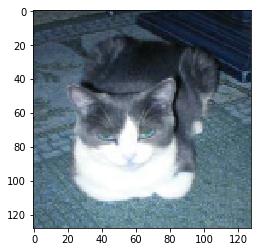

In [20]:
#view resized image
index = 88
plt.imshow(X_train[index]/255) #function wants values between 0 and 1, hence /255
print('y = ', labels[index])

### Reshape and flatten the data (unrolling)
* Want image shape to go from (n_px, n_px, 3) to (n_px * n_px * 3, 1)

In [21]:
X_train_flat = X_train.reshape(X_train.shape[0], -1).T
X_test_flat = X_test.reshape(X_test.shape[0], -1).T

print("X_train_flat shape:  ", str(X_train_flat.shape))
print("X_test_flat shape:  ", str(X_test_flat.shape))

X_train_flat shape:   (49152, 2000)
X_test_flat shape:   (49152, 1000)


### Standardize data set
* As opposed to the traditional preprocessing step of standardizing by substracting the mean and dividing by the standard deviation, we can just divide every row by 255 since this is a picture dataset

In [22]:
#Did not work on 25000 and 12500 dataset, works with 2000 and 1000
X_train_final = (X_train_flat/255)
X_test_final = (X_test_flat/255)

### Logistic Regression Quick Overview
* Can be viewed as a neural network with one unit and one layer

$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost function sums the losses for each example:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

See the this link for information on the [sigmoid function ](https://en.wikipedia.org/wiki/Sigmoid_function). It gives us a value between 0 and 1 where we predict 1 if 
$$\hat{y}^{(i)} > 0.5$$ and 0 otherwise.

The loss function is found by taking the negative log likelihood of the MLE for the parameter w. 

## Implement the necessary functions

### Sigmoid

In [23]:
'''
    Description: Computes the sigmoid of z
    
    Input: a scalar or numpy array
    
    Return: sigmoid(z)
'''
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    
    return s

In [24]:
#Test sigmoid
print("sigmoid(2) = ", sigmoid(2)) #expect .88
print("sigmoid([0.5, 1]) = ", sigmoid(np.array([0.5,1]))) #expect .6224 and .73106

sigmoid(2) =  0.8807970779778823
sigmoid([0.5, 1]) =  [0.62245933 0.73105858]


### Initialize parameters
* In logistic regression, it is okay to initialize weights to 0, not in neural networks

In [25]:
'''
    Description: initializes w to vector of zeros (dim, 1)
    
    Input: dimensions
    
    Return: W of shape=(dim, 1) and b which is a scalar here
'''
def init_params(dim):
    
    #add the second dimension to avoid weird python datatype
    w = np.zeros((dim, 1))
    b = 0
    
    return w,b

In [26]:
#Test initialization function
dim = 3
w, b = init_params(dim)
print("w = ", str(w))
print("b = ", str(b))

w =  [[0.]
 [0.]
 [0.]]
b =  0


### Forward and Backward propagation

In [27]:
'''
    Description: Propagates forward & backward in the network, calculating
        activations and gradients
    
    Input: weights, biases, training set X, vector of labels Y
    
    Returns: the loss (J), and the gradients (dw, and db)
'''
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    #Calculate activations and loss (negative log likelihood)
    A = sigmoid(np.dot(w.T, X) + b)
    loss = -np.sum((np.dot(Y, np.log(A.T)) + np.dot((1-Y), np.log(1-A.T))))/m
    
    #Backpropagate (compute gradients)
    dw = np.dot(X, (A-Y).T)/m
    db = np.sum(A-Y)/m
    
    #return gradients and loss
    loss = np.squeeze(loss)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, loss
    
    

In [29]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


### Gradient Descent Optimization

In [30]:
'''
    Description: Performs gradient descent, minimizing w and b
    
    Inputs: weights, biases, X (data), and Y (labels)
        number of iterations, learning rate when updating, and
        whether to print the cost or not every certain amt of steps
        
    Returns: params dictionary (w and b), grads (gradients of w and b),
        and costs (used to view learning curve)
'''
def optimize(w, b, X, Y, num_iter, learning_rate, print_cost = False):    
    
    costs = []
    
    #epochs
    for i in range(num_iter):
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        #update parametrs, w := w - alpha*dw, b := b - alpha*db
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        #check costs every 100 epochs
        if i % 100 == 0:
            costs.append(cost)
            
        if print_cost and i % 100 == 0:
            print('Cost after iteration ', i, ': ', cost)
            
    params = {"w": w,
              "b": b}
    grads = {"dw": dw,
             "db": db}
        
    return params, grads, costs

In [32]:
params, grads, costs = optimize(w, b, X, Y, num_iter= 500, learning_rate = 0.03, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[-1.0030841 ]
 [-0.35330579]]
b = 2.4773746865281443
dw = [[ 0.0576797 ]
 [-0.01337738]]
db = -0.04243082520504482


### Make Predictions
* $y_{hat} = \sigma(w^TX+b)$
* If $y_{hat} > .5$, predict 1 (dog)
* else, predict 0 (cat)

In [33]:
'''
    Description: Predicts 1 (dog) or 0 (cat) using sigmoid
    
    Input: weights, biases, training set X
    
    Returns: y_pred: a vector (numpy array) with all the predictions, thus size (1,m)
'''
def predict(w, b, X):
    
    m = X.shape[1]
    y_pred = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    #get probability
    A = sigmoid(np.dot(w.T, X) + b)
    
    #if y > 0.5, predict 1, else predict 0
    for i in range(A.shape[1]):
        if(A[0,i] > 0.5):
            y_pred[0, i] = 1
        else:
            y_pred[0, i] = 0
    
    return y_pred

In [34]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]
